# Test ORCParser Batch Processing Mode

This notebook tests the `process_page_batch_async` method which processes all identified blocks in a single LLM call, with bounding box coordinates included in the markdown output.


In [2]:
import os
import json
import asyncio
import hashlib
from pathlib import Path
from IPython.display import Image as IPythonImage, display, Markdown
from PIL import Image, ImageDraw, ImageFont

from aicapture import OCRParser, create_default_vision_model


Image path: ./data/c1.png
Image exists: True


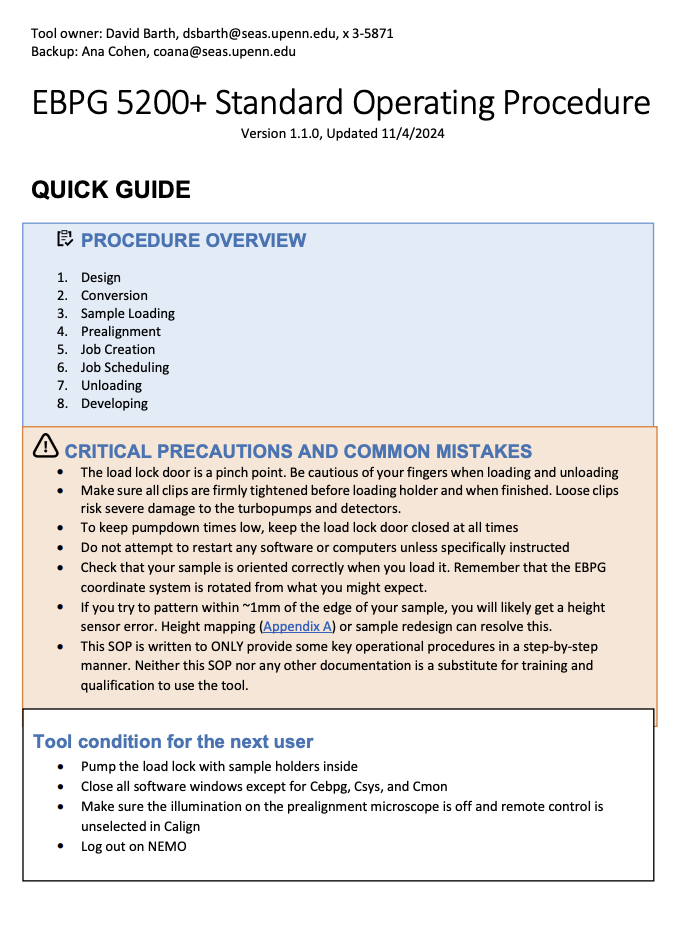

In [3]:
# Configuration
image_path = "./data/c1.png"
cache_dir = "./.orc_cache"

# Verify image exists
if not Path(image_path).exists():
    raise FileNotFoundError(f"Image not found: {image_path}")

print(f"Image path: {image_path}")
print(f"Image exists: {Path(image_path).exists()}")

# Display the image
display(IPythonImage(filename=image_path))


In [4]:
# Initialize ORCParser with auto-detected vision model
vision_model = create_default_vision_model()
print(f"Using vision model: {vision_model.__class__.__name__}")
print(f"Model: {vision_model.model}")

# Create ORCParser instance
# Set invalidate_cache=True to force reprocessing
parser = OCRParser(
    vision_model=vision_model,
    cache_dir=cache_dir,
    invalidate_cache=True,  # Set to False to use cache
    image_quality="high",
)


2025-11-16 13:43:03.262 | INFO     | aicapture.vision_models:create_default_vision_model:32 - Creating vision model for provider: gemini
2025-11-16 13:43:03.262 | DEBUG    | aicapture.vision_models:__init__:135 - Using GeminiVisionModel
API Key: AIza***********************************
API Base: https://generativelanguage.googleapis.com/v1beta/openai/
Model: gemini-2.5-pro

2025-11-16 13:43:03.263 | WARNING  | aicapture.cache:__init__:355 - Parent directory .orc_cache does not exist. Creating it.
2025-11-16 13:43:03.264 | DEBUG    | aicapture.cache:__init__:360 - Initialized image cache at .orc_cache/images
2025-11-16 13:43:03.264 | DEBUG    | aicapture.cache:__init__:80 - Initialized file cache at .orc_cache


Using vision model: GeminiVisionModel
Model: gemini-2.5-pro


In [5]:
# Load the image
img = Image.open(image_path).convert("RGB")
img_width, img_height = img.size
print(f"Image size: {img_width}x{img_height} pixels")

# Generate page hash (required for process_page_batch_async)
with open(image_path, "rb") as f:
    image_bytes = f.read()
    page_hash = hashlib.sha256(image_bytes).hexdigest()[:16]

print(f"Page hash: {page_hash}")


Image size: 694x928 pixels
Page hash: ae2420532cc3a652


In [8]:
import nest_asyncio
nest_asyncio.apply()

# First, identify blocks to see what will be processed
img = Image.open(image_path).convert("RGB")
img_width, img_height = img.size
print(f"Image size: {img_width}x{img_height} pixels")

# Identify document blocks
print("\nIdentifying document blocks...")
blocks = asyncio.run(parser._identify_blocks_async(img))

print(f"\nFound {len(blocks)} document blocks:")
for i, block in enumerate(blocks, 1):
    block_type = block["type"]
    bbox = block["bbox"]
    # bbox format: [ymin, xmin, ymax, xmax] normalized to 0-1000
    xmin_norm, ymin_norm, xmax_norm, ymax_norm = bbox
    
    # Convert normalized coordinates to pixels
    xmin = int(xmin_norm / 1000.0 * img_width)
    ymin = int(ymin_norm / 1000.0 * img_height)
    xmax = int(xmax_norm / 1000.0 * img_width)
    ymax = int(ymax_norm / 1000.0 * img_height)
    
    print(f"  Block {i}: {block_type}")
    print(f"    Normalized BBox: [ymin={ymin_norm:.1f}, xmin={xmin_norm:.1f}, ymax={ymax_norm:.1f}, xmax={xmax_norm:.1f}]")
    print(f"    Pixel BBox: [x={xmin}, y={ymin}, width={xmax-xmin}, height={ymax-ymin}]")
    print()
    




2025-11-16 13:44:26.343 | DEBUG    | aicapture.ocr_parser:_identify_blocks_async:196 - Identifying document blocks...


Image size: 694x928 pixels

Identifying document blocks...


2025-11-16 13:44:42.777 | INFO     | aicapture.vision_models:log_token_usage:152 - Token usage: {'prompt_tokens': 471, 'completion_tokens': 275, 'total_tokens': 1844}
2025-11-16 13:44:42.777 | INFO     | aicapture.ocr_parser:_identify_blocks_async:234 - Identified 6 document blocks



Found 6 document blocks:
  Block 1: text
    Normalized BBox: [ymin=41.0, xmin=43.0, ymax=76.0, xmax=571.0]
    Pixel BBox: [x=29, y=38, width=367, height=32]

  Block 2: text
    Normalized BBox: [ymin=99.0, xmin=43.0, ymax=145.0, xmax=863.0]
    Pixel BBox: [x=29, y=91, width=569, height=43]

  Block 3: text
    Normalized BBox: [ymin=190.0, xmin=44.0, ymax=211.0, xmax=221.0]
    Pixel BBox: [x=30, y=176, width=123, height=19]

  Block 4: text
    Normalized BBox: [ymin=240.0, xmin=44.0, ymax=435.0, xmax=465.0]
    Pixel BBox: [x=30, y=222, width=292, height=181]

  Block 5: text
    Normalized BBox: [ymin=465.0, xmin=44.0, ymax=745.0, xmax=916.0]
    Pixel BBox: [x=30, y=431, width=605, height=260]

  Block 6: text
    Normalized BBox: [ymin=768.0, xmin=44.0, ymax=936.0, xmax=884.0]
    Pixel BBox: [x=30, y=712, width=583, height=156]



IMAGE WITH BOUNDING BOXES
Image size: 694x928 pixels
Total blocks drawn: 6

Block type colors:
  text: blue
  table: red
  figure: green
  math_formula: purple
  diagram: orange
  image: yellow


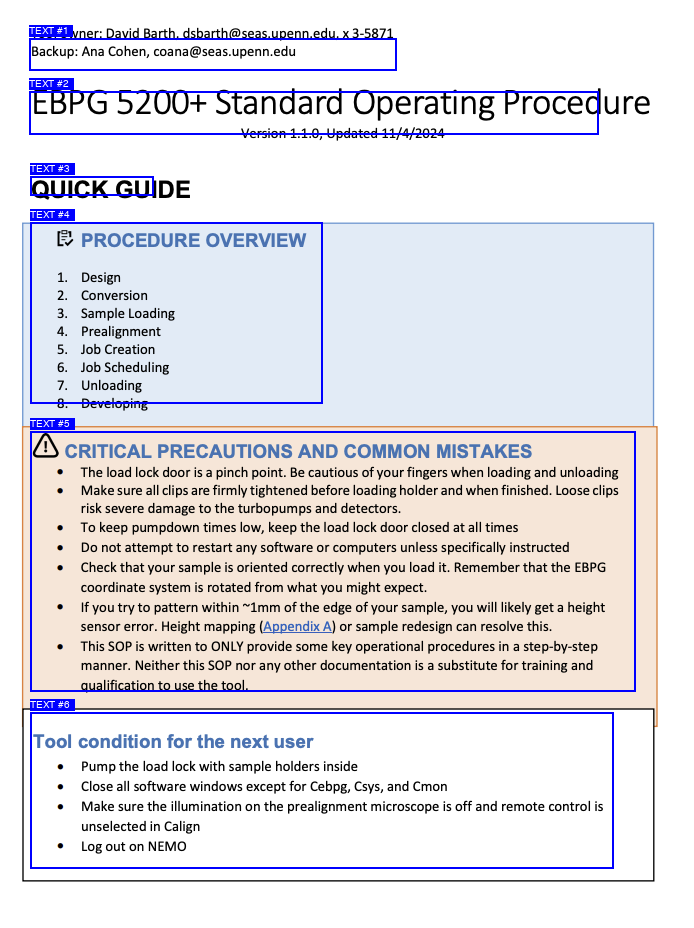

In [10]:
# Draw bounding boxes on the image
# Create a copy to avoid modifying the original
img_with_boxes = img.copy()
draw = ImageDraw.Draw(img_with_boxes)

# Color mapping for different block types
block_colors = {
    "text": "blue",
    "table": "red",
    "figure": "green",
    "math_formula": "purple",
    "diagram": "orange",
    "image": "yellow",
}

# Draw each block with its bounding box
for i, block in enumerate(blocks, 1):
    block_type = block["type"]
    bbox = block["bbox"]
    
    # bbox format from ORCParser: [ymin, xmin, ymax, xmax] normalized to 0-1000
    xmin_norm, ymin_norm, xmax_norm, ymax_norm = bbox
    
    # Convert normalized coordinates (0-1000) to pixel coordinates
    xmin = int(xmin_norm / 1000.0 * img_width)
    ymin = int(ymin_norm / 1000.0 * img_height)
    xmax = int(xmax_norm / 1000.0 * img_width)
    ymax = int(ymax_norm / 1000.0 * img_height)
    
    # Clamp to image bounds
    xmin = max(0, min(xmin, img_width - 1))
    ymin = max(0, min(ymin, img_height - 1))
    xmax = max(xmin + 1, min(xmax, img_width))
    ymax = max(ymin + 1, min(ymax, img_height))
    
    # Get color for this block type (default to gray if unknown)
    color = block_colors.get(block_type, "gray")
    
    # Draw rectangle (PIL uses [x0, y0, x1, y1] format)
    draw.rectangle(
        [xmin, ymin, xmax, ymax],
        outline=color,
        width=2
    )
    
    # Add label with block type and number
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 10)
    except:
        try:
            font = ImageFont.load_default()
        except:
            font = None
    
    label = f"{block_type.upper()} #{i}"
    # Position label above the box
    label_y = max(5, ymin - 12)
    
    # Draw text background
    if font:
        text_bbox = draw.textbbox((xmin+2, label_y), label, font=font)
        if text_bbox:
            # Expand background slightly for padding
            bg_x0, bg_y0, bg_x1, bg_y1 = text_bbox
            draw.rectangle(
                [bg_x0 - 2, bg_y0 - 2, bg_x1 + 2, bg_y1 + 2],
                fill=color,
                outline=color
            )
            draw.text((xmin, label_y), label, fill="white", font=font)
        else:
            draw.text((xmin, label_y), label, fill=color, font=font)
    else:
        draw.text((xmin, label_y), label, fill=color)

# Display the annotated image
print("=" * 80)
print("IMAGE WITH BOUNDING BOXES")
print("=" * 80)
print(f"Image size: {img_width}x{img_height} pixels")
print(f"Total blocks drawn: {len(blocks)}")
print("\nBlock type colors:")
for block_type, color in block_colors.items():
    print(f"  {block_type}: {color}")

display(img_with_boxes)


In [11]:
# Test the batch processing method
print("=" * 80)
print("TESTING process_page_batch_async")
print("=" * 80)
print("\nThis method:")
print("1. Identifies all blocks (already done above)")
print("2. Processes the whole image with all blocks in a SINGLE LLM call")
print("3. Returns extracted content with bbox coordinates in markdown")
print("\nProcessing...\n")

result = asyncio.run(
    parser.process_page_async(
        image=img,
        page_number=1,
        page_hash=page_hash,
        text_content=""
    )
)

print(f"Page number: {result['page_number']}")
print(f"Confident score: {result['confident_score']}")
print(f"Confident reason: {result['confident_reason']}")
print(f"\nPage content length: {len(result['page_content'])} characters")


2025-11-16 13:45:16.595 | DEBUG    | aicapture.ocr_parser:process_page_async:281 - Processing page 1 with ORCParser (batch mode)
2025-11-16 13:45:16.595 | DEBUG    | aicapture.ocr_parser:_identify_blocks_async:196 - Identifying document blocks...


TESTING process_page_batch_async

This method:
1. Identifies all blocks (already done above)
2. Processes the whole image with all blocks in a SINGLE LLM call
3. Returns extracted content with bbox coordinates in markdown

Processing...



2025-11-16 13:45:57.063 | INFO     | aicapture.vision_models:log_token_usage:152 - Token usage: {'prompt_tokens': 471, 'completion_tokens': 234, 'total_tokens': 4851}
2025-11-16 13:45:57.064 | INFO     | aicapture.ocr_parser:_identify_blocks_async:234 - Identified 6 document blocks
2025-11-16 13:45:57.064 | DEBUG    | aicapture.ocr_parser:process_page_async:295 - Batch extraction prompt: 
    Extract each content block SEPARATELY.

    
<GENERAL_INSTRUCTIONS>
Extract the document content, following these guidelines:

Text Content:
- Extract all text in correct reading order, preserving original formatting and hierarchy
- Maintain section headers, subheaders, and their relationships
- Include all numerical values, units, and technical specifications,
- DO NOT summarize the content or skip any sections, we need all the details as possible.

Tables:
- Convert to markdown format with clear column headers, keep the nested structure as it is.
- Preserve all numerical values, units, and relat

Page number: 1
Confident score: 100
Confident reason: Document is a high-quality, digitally-born PDF. The text is perfectly clear and legible, and all content was extracted without any ambiguities or errors.

Page content length: 1910 characters


In [12]:
# Display the extracted content
print("=" * 80)
print("EXTRACTED CONTENT (with bbox coordinates)")
print("=" * 80)
display(Markdown(result['page_content']))


EXTRACTED CONTENT (with bbox coordinates)


<|ref|>text<|/ref|><|det|>[[29, 39, 396, 74]]<|/det|>
Tool owner: David Barth, dsbarth@seas.upenn.edu, x 3-5871
Backup: Ana Cohen, coana@seas.upenn.edu

<|ref|>text<|/ref|><|det|>[[29, 92, 596, 139]]<|/det|>
# EBPG 5200+ Standard Operating Procedure
Version 1.1.0, Updated 11/4/2024

<|ref|>text<|/ref|><|det|>[[29, 174, 152, 199]]<|/det|>
# QUICK GUIDE

<|ref|>text<|/ref|><|det|>[[29, 220, 664, 399]]<|/det|>
## 📖 PROCEDURE OVERVIEW
1. Design
2. Conversion
3. Sample Loading
4. Prealignment
5. Job Creation
6. Job Scheduling
7. Unloading
8. Developing

<|ref|>text<|/ref|><|det|>[[29, 434, 664, 686]]<|/det|>
## ⚠ CRITICAL PRECAUTIONS AND COMMON MISTAKES
* The load lock door is a pinch point. Be cautious of your fingers when loading and unloading
* Make sure all clips are firmly tightened before loading holder and when finished. Loose clips risk severe damage to the turbopumps and detectors.
* To keep pumpdown times low, keep the load lock door closed at all times
* Do not attempt to restart any software or computers unless specifically instructed
* Check that your sample is oriented correctly when you load it. Remember that the EBPG coordinate system is rotated from what you might expect.
* If you try to pattern within ~1mm of the edge of your sample, you will likely get a height sensor error. Height mapping (Appendix A) or sample redesign can resolve this.
* This SOP is written to ONLY provide some key operational procedures in a step-by-step manner. Neither this SOP nor any other documentation is a substitute for training and qualification to use the tool.

<|ref|>text<|/ref|><|det|>[[29, 708, 664, 863]]<|/det|>
## Tool condition for the next user
* Pump the load lock with sample holders inside
* Close all software windows except for Cebpg, Csys, and Cmon
* Make sure the illumination on the prealignment microscope is off and remote control is unselected in Calign
* Log out on NEMO

Extracted 6 blocks from the response:
  Block 1: text - bbox: [ymin=39, xmin=29, ymax=74, xmax=396]
  Block 2: text - bbox: [ymin=92, xmin=29, ymax=139, xmax=596]
  Block 3: text - bbox: [ymin=174, xmin=29, ymax=199, xmax=152]
  Block 4: text - bbox: [ymin=220, xmin=29, ymax=399, xmax=664]
  Block 5: text - bbox: [ymin=434, xmin=29, ymax=686, xmax=664]
  Block 6: text - bbox: [ymin=708, xmin=29, ymax=863, xmax=664]

IMAGE WITH BBOX FROM BATCH RESPONSE
Image size: 694x928 pixels
Total blocks drawn: 6

Block type colors:
  text: blue
  table: red
  figure: green
  math_formula: purple
  diagram: orange
  image: yellow


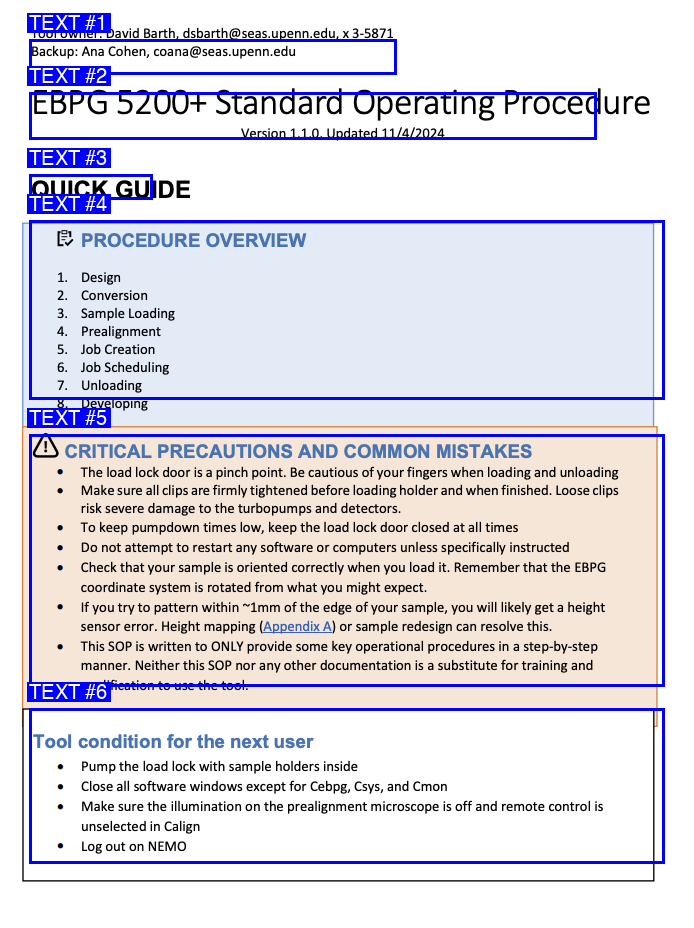

In [13]:
# Extract bbox coordinates from the batch response and draw boxes on the image
import re

# Parse the page_content to extract bbox coordinates
# Format: <|ref|>{block_type}<|/ref|><|det|>[[{ymin}, {xmin}, {ymax}, {xmax}]]<|/det|>
ref_pattern = re.compile(r"<\|ref\|>(\w+)<\|/ref\|>")
det_pattern = re.compile(r"<\|det\|>\[\[([\d,\s]+)\]\]<\|/det\|>")

# Extract all blocks with their bboxes
extracted_blocks = []
content_lines = result['page_content'].split('\n')

i = 0
while i < len(content_lines):
    line = content_lines[i].strip()
    
    # Check for <|ref|> tag (block type)
    ref_match = ref_pattern.search(line)
    if ref_match:
        block_type = ref_match.group(1).lower()
        
        # Check for <|det|> tag (bbox) on the same line or next line
        det_match = det_pattern.search(line)
        if not det_match and i + 1 < len(content_lines):
            det_match = det_pattern.search(content_lines[i + 1].strip())
        
        if det_match:
            # Extract bbox coordinates (in pixels)
            bbox_str = det_match.group(1)
            bbox_parts = [int(x.strip()) for x in bbox_str.split(",")]
            if len(bbox_parts) == 4:
                ymin_px, xmin_px, ymax_px, xmax_px = bbox_parts
                extracted_blocks.append({
                    "type": block_type,
                    "bbox": [ymin_px, xmin_px, ymax_px, xmax_px]
                })
    i += 1

print(f"Extracted {len(extracted_blocks)} blocks from the response:")
for i, block in enumerate(extracted_blocks, 1):
    xmin, ymin, xmax, ymax = block["bbox"]
    print(f"  Block {i}: {block['type']} - bbox: [ymin={ymin}, xmin={xmin}, ymax={ymax}, xmax={xmax}]")

# Draw bounding boxes on the image
img_with_bboxes = img.copy()
draw = ImageDraw.Draw(img_with_bboxes)

# Color mapping for different block types
block_colors = {
    "text": "blue",
    "table": "red",
    "figure": "green",
    "math_formula": "purple",
    "diagram": "orange",
    "image": "yellow",
}

# Draw each extracted block
for i, block in enumerate(extracted_blocks, 1):
    block_type = block["type"]
    xmin, ymin, xmax, ymax = block["bbox"]
    
    # Clamp to image bounds
    xmin = max(0, min(xmin, img_width - 1))
    ymin = max(0, min(ymin, img_height - 1))
    xmax = max(xmin + 1, min(xmax, img_width))
    ymax = max(ymin + 1, min(ymax, img_height))
    
    # Get color for this block type
    color = block_colors.get(block_type, "gray")
    
    # Draw rectangle (PIL uses [x0, y0, x1, y1] format)
    draw.rectangle(
        [xmin, ymin, xmax, ymax],
        outline=color,
        width=3
    )
    
    # Add label with block type and number
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    except:
        try:
            font = ImageFont.load_default()
        except:
            font = None
    
    label = f"{block_type.upper()} #{i}"
    # Position label above the box
    label_y = max(5, ymin - 25)
    
    # Draw text background
    if font:
        text_bbox = draw.textbbox((xmin, label_y), label, font=font)
        if text_bbox:
            bg_x0, bg_y0, bg_x1, bg_y1 = text_bbox
            draw.rectangle(
                [bg_x0 - 2, bg_y0 - 2, bg_x1 + 2, bg_y1 + 2],
                fill=color,
                outline=color
            )
            draw.text((xmin, label_y), label, fill="white", font=font)
        else:
            draw.text((xmin, label_y), label, fill=color, font=font)
    else:
        draw.text((xmin, label_y), label, fill=color)

# Display the annotated image
print("\n" + "=" * 80)
print("IMAGE WITH BBOX FROM BATCH RESPONSE")
print("=" * 80)
print(f"Image size: {img_width}x{img_height} pixels")
print(f"Total blocks drawn: {len(extracted_blocks)}")
print("\nBlock type colors:")
for block_type, color in block_colors.items():
    print(f"  {block_type}: {color}")

display(img_with_bboxes)


In [ ]:
# Show the raw content for inspection
print("=" * 80)
print("RAW EXTRACTED CONTENT")
print("=" * 80)
print(result['page_content'])


In [ ]:
# Compare with regular process_page_async for comparison
print("=" * 80)
print("COMPARISON: Regular process_page_async (for reference)")
print("=" * 80)
print("\nThis processes each block separately with individual LLM calls.\n")

regular_result = asyncio.run(
    parser.process_page_async(
        image=img,
        page_number=1,
        page_hash=page_hash,
        text_content=""
    )
)

print(f"Regular mode - Confident score: {regular_result['confident_score']}")
print(f"Regular mode - Confident reason: {regular_result['confident_reason']}")
print(f"Regular mode - Content length: {len(regular_result['page_content'])} characters")
print(f"\nBatch mode - Confident score: {result['confident_score']}")
print(f"Batch mode - Confident reason: {result['confident_reason']}")
print(f"Batch mode - Content length: {len(result['page_content'])} characters")


In [ ]:
# Save results to file for inspection
output_dir = Path("tmp/batch_orc_results")
output_dir.mkdir(parents=True, exist_ok=True)

# Save batch result
batch_output_path = output_dir / f"{Path(image_path).stem}_batch.md"
with open(batch_output_path, "w", encoding="utf-8") as f:
    f.write(result['page_content'])
print(f"Batch result saved to: {batch_output_path}")

# Save regular result for comparison
regular_output_path = output_dir / f"{Path(image_path).stem}_regular.md"
with open(regular_output_path, "w", encoding="utf-8") as f:
    f.write(regular_result['page_content'])
print(f"Regular result saved to: {regular_output_path}")
